In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def prepare(fname:str, category:str, date_format: str):
    df = pd.read_csv(fname)
    df = pd.melt(df, id_vars=['Province/State', 'Country/Region'], value_vars=[c for c in df.columns if c[0] in '0123456789']) \
           .rename(columns={'variable':'period', 'value': category, 'Province/State': 'province', 'Country/Region': 'country'})
    
    # Parse date from perdiod string and remove the period string as
    # it confuses the following merge processess
    df['date'] = pd.to_datetime(df['period'], format=date_format)
    df = df[[c for c in df.columns if c != 'period']]
    
    return df

dfc = prepare('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 'confirmed', '%m/%d/%y')
dfd = prepare('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', 'deaths', '%m/%d/%y')
dfr = prepare('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv', 'recovered', '%m/%d/%y')

df = pd.merge(dfc, dfd)
df = pd.merge(df, dfr)
df = df.groupby([df.country, df.date]).sum().reset_index()

## France / Italy comparison

A comparison of the progress of declared cases between France and Italy.

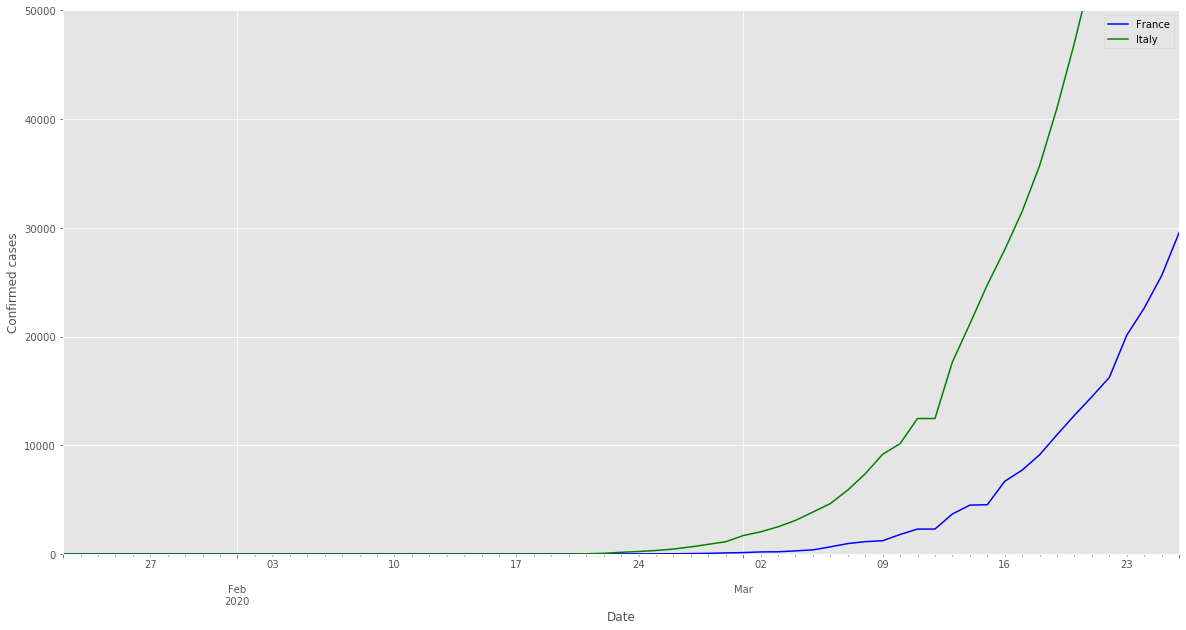

In [2]:
ax = df[['country','date','confirmed']][(df.country == 'France')] \
        .groupby(df.date).sum().rename(columns={'confirmed':'France'}) \
        .plot(figsize=(20,10), ylim=(0,50000), color='blue')

df[['country','date','confirmed']][(df.country == 'Italy')] \
        .groupby('date').sum().rename(columns={'confirmed':'Italy'}) \
        .plot(ax=ax, color='green')

ax.set_xlabel("Date")
ax.set_ylabel("Confirmed cases")
plt.show()

## France / Italy / China comparison

Projection of France vs. China and Italy with time shifting.

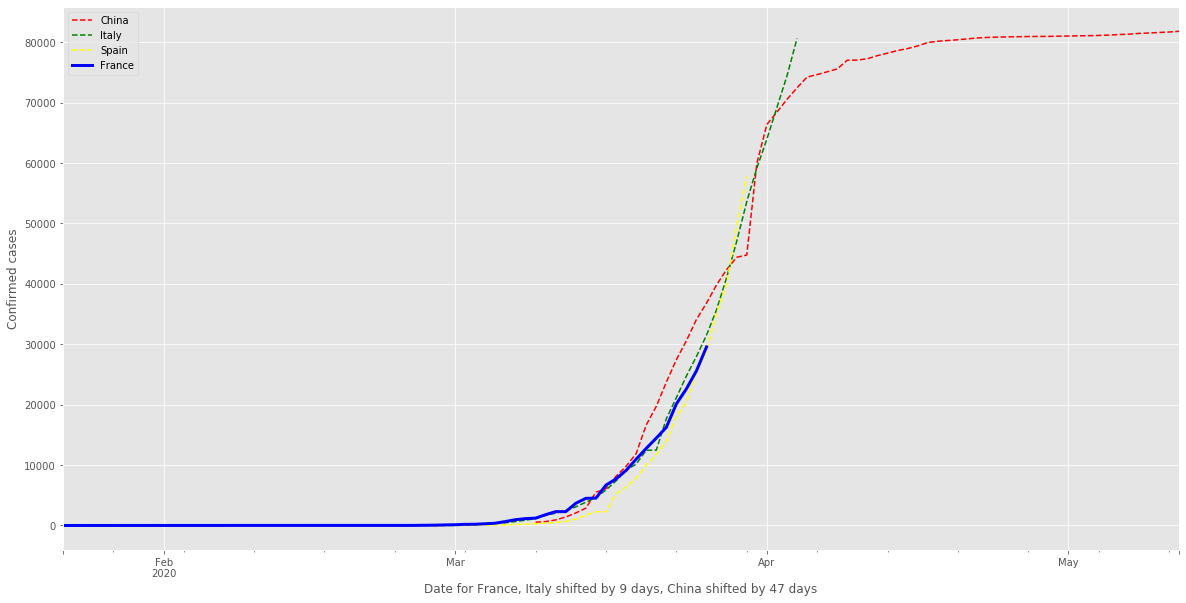

In [10]:
ax = None

shift_china=47
shift_italy=9
shift_spain=4

ax = df[['country','date','confirmed']][(df.country == 'China')] \
        .assign(date_shift=df.date + pd.DateOffset(days=shift_china), confirmed=df.confirmed) \
        .groupby('date_shift').sum().rename(columns={'confirmed':'China'}) \
        .plot(ax=ax, figsize=(20,10), color='red', linestyle='dashed')

ax = df[['country','date','confirmed']][(df.country == 'Italy')] \
        .assign(date_shift=df.date + pd.DateOffset(days=shift_italy)) \
        .groupby('date_shift').sum().rename(columns={'confirmed':'Italy'}) \
        .plot(ax=ax, color='green', linestyle='dashed')

ax = df[['country','date','confirmed']][(df.country == 'Spain')] \
        .assign(date_shift=df.date + pd.DateOffset(days=shift_spain)) \
        .groupby('date_shift').sum().rename(columns={'confirmed':'Spain'}) \
        .plot(ax=ax, color='yellow', linestyle='dashed')
 
ax = df[['country','date','confirmed']][(df.country == 'France')] \
        .groupby(df.date).sum().rename(columns={'confirmed':'France'}) \
        .plot(ax=ax, color='blue', linewidth=3)

ax.set_xlabel("Date for France, Italy shifted by %d days, China shifted by %d days" % (shift_italy, shift_china))
ax.set_ylabel("Confirmed cases")
plt.show()

## Linar regression on France based on China Data

TODO: This section is in progress

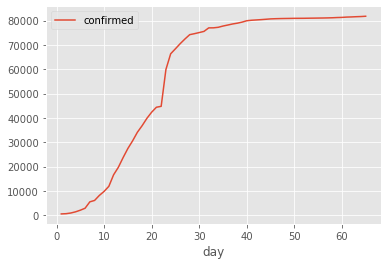

In [4]:
df_china = df[(df.country == 'China')]
df_china = df_china.assign(delta=df_china.date - pd.Timestamp('2020-01-20 12:00:00'))
df_china = df_china.assign(day=df_china.delta.dt.days)
df_china = df_china[['day', 'confirmed']].groupby('day').sum()

df_china.plot()

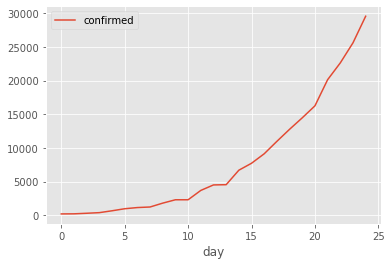

In [5]:
df_france = df[(df.country == 'France')]
df_france = df_france.assign(delta=df_france.date - pd.Timestamp('2020-03-01 12:00:00'))
df_france = df_france.assign(day=df_france.delta.dt.days)
df_france = df_france[df_france.day >= 0]
df_france = df_france[['day', 'confirmed']].groupby('day').sum()

df_france.plot()

In [6]:
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

# X = pd.DataFrame(df[‘OAT (F)’])
# y = pd.DataFrame(df[‘Power (kW)’])model = LinearRegression()
# scores = []
# kfold = KFold(n_splits=3, shuffle=True, random_state=42)
# for i, (train, test) in enumerate(kfold.split(X, y)):
#  model.fit(X.iloc[train,:], y.iloc[train,:])
#  score = model.score(X.iloc[test,:], y.iloc[test,:])
#  scores.append(score)print(scores)